<h2><center><font color=#D40004><u> Прогнозирование потребления электроэнергии  </u></font></center></h2>
<h3><center> Команда Continue на основе исследования Maria GALMAN, and NECHBA Mohammed</center></h3>
<br>


# Цель этого проекта
Основной целью этого проекта является разработка надежной модели для прогнозирования потребления электроэнергии в Тетуане, Марокко. Используя исторические данные и погодные условия, мы стремимся создать точный инструмент прогнозирования, который поможет оптимизировать управление энергопотреблением в городе. Достигая этой цели, мы стремимся повысить надежность энергоснабжения, поддерживать принятие решений в области энергетической политики на основе данных и продвигать практику устойчивого использования энергии в Тетуане. Эта прогностическая модель позволит нам проактивно реагировать на колебания спроса на энергию, особенно в экстремальных погодных условиях, и способствовать эффективному распределению электрических ресурсов.

# Dataset
Данные, используемые в этом скрипте, взяты из [Kaggle's Electric Power Consumption dataset](https://www.kaggle.com/datasets/fedesoriano/electric-power-consumption). Этот набор данных представляет собой CSV-файл с тремя столбцами данных о потреблении электроэнергии, записываемых с частотой 6 выборок в час (1 выборка каждые 10 минут). Каждый из этих 3 столбцов представляет зону города Тетуан в Марокко.

**Признаки**:
* **Date Time**: Временной интервал - десять минут.
* **Temperature**: Погодная температура.
* **Humidity**: Влажность воздуха.
* **Wind Speed**: Скорость ветра.
* **General Diffuse Flows**: “Диффузный поток” - это общий термин для описания низкотемпературных (от < 0,2° до ~ 100°C) флюидов, которые медленно вытекают через сульфидные насыпи, трещиноватые потоки лавы и скопления бактериальных матов и макрофауны.
* **Diffuse Flows**

**Целевая метка**:
*  **Zone 1 Power Consumption**
*  **Zone 2 Power Consumption**
*  **Zone 3 Power Consumption**

## <p style="background-color:skyblue; font-family:newtimeroman; font-size:120%; text-align:center">Table of Content</p>

* [I. Импорт/загрузка и проверка данных](#1)
* [II. Визуализация данных 📊](#2)
* [III. Предварительная обработка данных ⚙️](#3)
    * [III.1 Исправление пропусков в данных](#3.1)
    
* [IV. Работа с признаками 🔧](#4)
* [V. Предварительный анализ данных 📊](#5)
* [VI. Инициализация модели](#5)
     * [VI.1. Xgboost модель](#6.4)
* [6. Выводы](#7)
* [7. Ссылки на источники](#8)

<a id='1'></a>
 # <p style="background-color:skyblue; font-family:newtimeroman; font-size:150%; text-align:center">I. Импорт/загрузка и проверка данных:</p>

In [1]:
%%time
# Import packages and modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from xgboost import XGBRegressor, plot_importance
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

CPU times: user 2.92 s, sys: 322 ms, total: 3.24 s
Wall time: 7.78 s


In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("fedesoriano/electric-power-consumption")

print("Path to dataset files:", path)

100%|██████████| 1.36M/1.36M [00:01<00:00, 1.41MB/s]

Extracting files...
Path to dataset files: /root/.cache/kagglehub/datasets/fedesoriano/electric-power-consumption/versions/1


In [3]:
!ls $path

powerconsumption.csv


In [4]:
%%time
# Load Dataset
df  = pd.read_csv(path + '/powerconsumption.csv')

CPU times: user 62.4 ms, sys: 10.2 ms, total: 72.6 ms
Wall time: 74.7 ms


In [5]:
%%time
df.head() #Show the first lines of the dataframe

CPU times: user 140 µs, sys: 0 ns, total: 140 µs
Wall time: 145 µs


,Datetime,Temperature,Humidity,WindSpeed,GeneralDiffuseFlows,DiffuseFlows,PowerConsumption_Zone1,PowerConsumption_Zone2,PowerConsumption_Zone3
0,1/1/2017 0:00,6.559,73.8,0.083,0.051,0.119,34055.69620,16128.87538,20240.96386
1,1/1/2017 0:10,6.414,74.5,0.083,0.070,0.085,29814.68354,19375.07599,20131.08434
2,1/1/2017 0:20,6.313,74.5,0.080,0.062,0.100,29128.10127,19006.68693,19668.43373
3,1/1/2017 0:30,6.121,75.0,0.083,0.091,0.096,28228.86076,18361.09422,18899.27711
4,1/1/2017 0:40,5.921,75.7,0.081,0.048,0.085,27335.69620,17872.34043,18442.40964


<a id='2'></a>
 # <p style="background-color:skyblue; font-family:newtimeroman; font-size:150%; text-align:center">II. Визуализация данных 📊</p>

In [6]:
%%time
# Data Visualization
# Pairplot to visualize relationships between numerical columns
sns.pairplot(df[['Temperature', 'Humidity', 'WindSpeed', 'PowerConsumption_Zone1', 'PowerConsumption_Zone2', 'PowerConsumption_Zone3']])
plt.show()


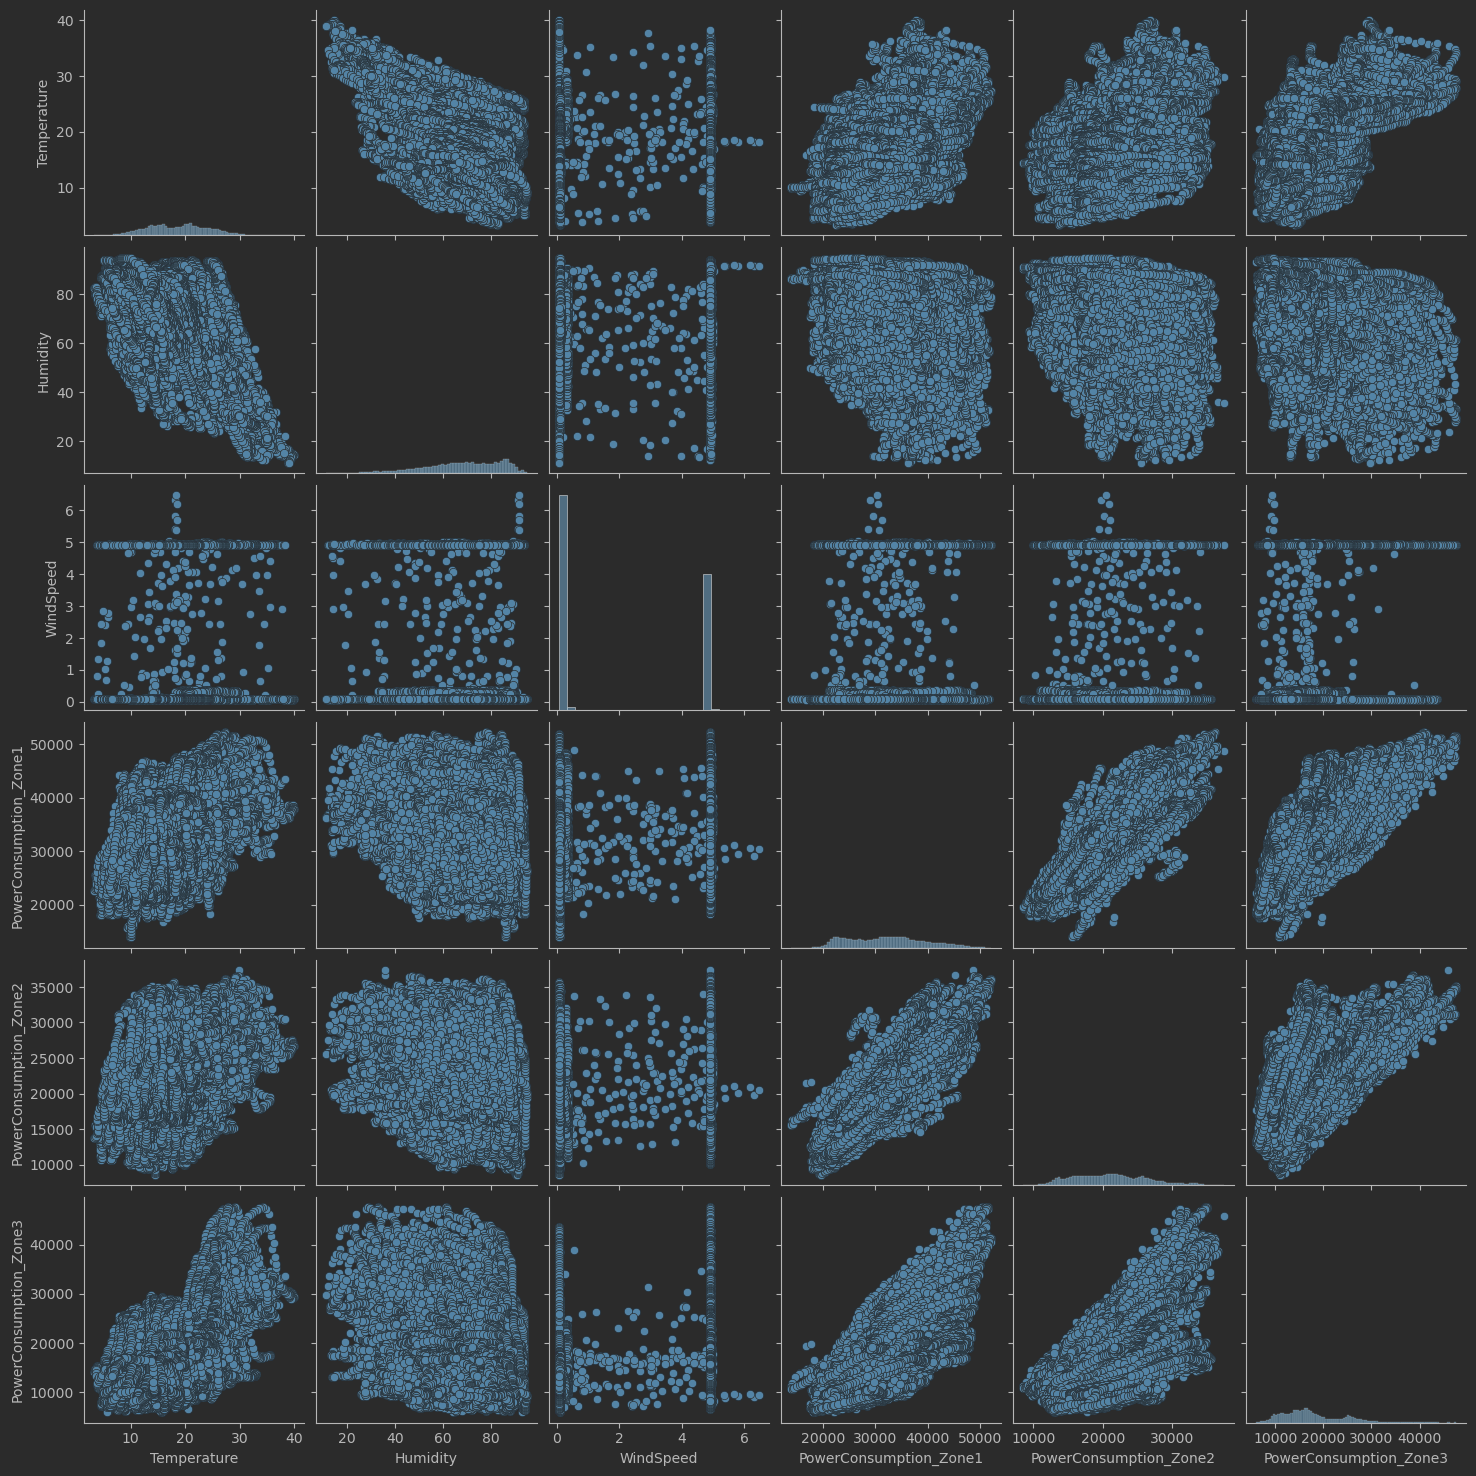

In [7]:
%%time
# График временных рядов для измерения энергопотребления
plt.figure(figsize=(12, 6))
sns.lineplot(x='Datetime', y='PowerConsumption_Zone1', data=df, label='Zone 1')
plt.xlabel('Datetime')
plt.ylabel('Power Consumption')
plt.title('Power Consumption Over Time')
plt.show()

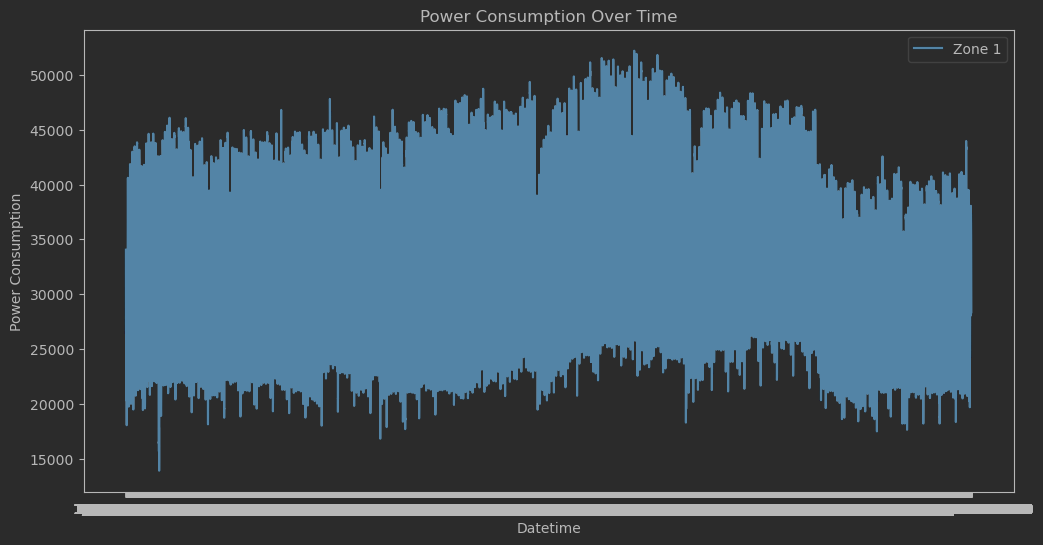

In [8]:
%%time
# Time series plot for PowerConsumption
plt.figure(figsize=(12, 6))
sns.lineplot(x='Datetime', y='PowerConsumption_Zone2', data=df, label='Zone 2')
plt.xlabel('Datetime')
plt.ylabel('Power Consumption')
plt.title('Power Consumption Over Time')
plt.show()

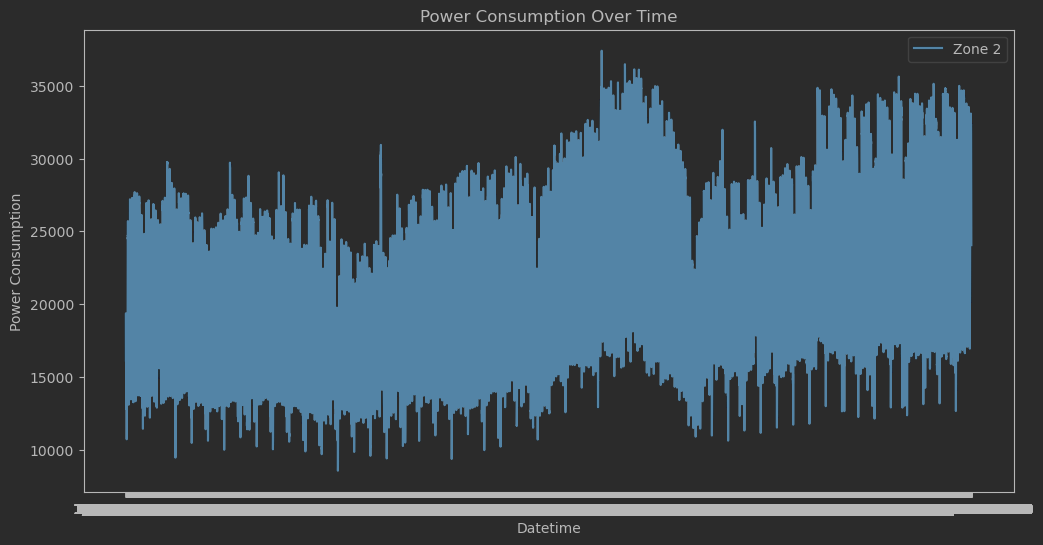

In [9]:
%%time
# График временных рядов для определения энергопотребления
plt.figure(figsize=(12, 6))
sns.lineplot(x='Datetime', y='PowerConsumption_Zone3', data=df, label='Zone 3')
plt.xlabel('Datetime')
plt.ylabel('Power Consumption')
plt.title('Power Consumption Over Time')
plt.show()

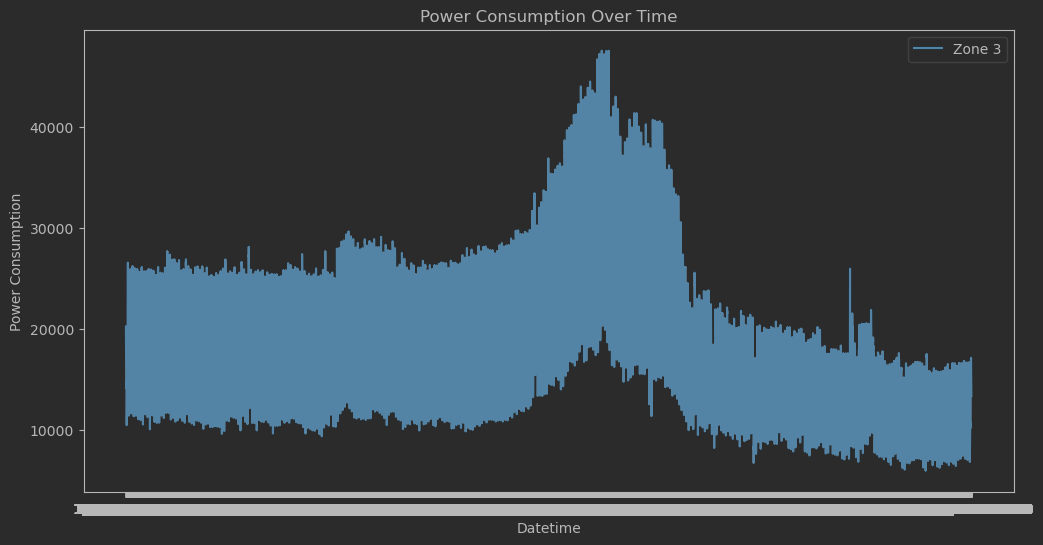

<a id='3'></a>
# <p style="background-color:skyblue; font-family:newtimeroman; font-size:150%; text-align:center">III. Предварительная обработка данных ⚙️</p>

## Хронологический порядок и равноудаленные временные метки

Данные должны располагаться в хронологическом порядке, а временные метки должны быть равноудалены от временных рядов. Хронологический порядок может быть достигнут путем сортировки фрейма данных по временным меткам. Равноудаленные временные метки указывают на постоянные временные интервалы. Чтобы проверить это, можно использовать разницу между каждой временной меткой. Если это не так, вы можете выбрать постоянный временной интервал и повторно выполнить выборку данных.

Но, прежде всего, давайте посмотрим, как проверить, правильно ли сформирован наш набор данных!

In [10]:
%%time
df['Datetime']=pd.to_datetime(df.Datetime)
df.sort_values(by='Datetime', ascending=True, inplace=True)

chronological_order = df['Datetime'].is_monotonic_increasing

time_diffs = df['Datetime'].diff()
equidistant_timestamps = time_diffs.nunique() == 1

CPU times: user 180 ms, sys: 2.97 ms, total: 183 ms
Wall time: 188 ms


In [11]:
%%time
chronological_order, equidistant_timestamps

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 7.39 µs


(True, True)

Это уже имеет место в наших данных: временной интервал составляет 10 минут, и данные уже расположены в хронологическом порядке. Таким образом, нам не нужно выполнять этот дополнительный этап подготовки данных.

<a id='3.1'></a>
## <p style="background-color:skyblue; font-family:newtimeroman; font-size:120%; text-align:center">III.1 Заполнение пропусков в данных</p>


Мы видим, что в наборе данных нет пропущенных значений.

In [12]:
%%time
df.isna().sum()

CPU times: user 2.51 ms, sys: 0 ns, total: 2.51 ms
Wall time: 3.3 ms


,0
Datetime,0
Temperature,0
Humidity,0
WindSpeed,0
GeneralDiffuseFlows,0
DiffuseFlows,0
PowerConsumption_Zone1,0
PowerConsumption_Zone2,0
PowerConsumption_Zone3,0


<a id='4'></a>
# <p style="background-color:skyblue; font-family:newtimeroman; font-size:150%; text-align:center">IV. Работа с признаками 🔧</p>

In [13]:
def create_features(df):
    """
    Create time series features based on time series index.
    """
    df = df.copy()
    df['hour'] = df.index.hour
    df['minute'] = df.index.minute
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['day'] = df.index.month
    df['year'] = df.index.year
    df['season'] = df['month'] % 12 // 3 + 1
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.isocalendar().week

    # Дополнительные признаки
    df['is_weekend'] = df['dayofweek'].isin([5, 6]).astype(int)
    df['is_month_start'] = (df['dayofmonth'] == 1).astype(int)
    df['is_month_end'] = (df['dayofmonth'] == df.index.days_in_month).astype(int)
    df['is_quarter_start'] = (df['dayofmonth'] == 1) & (df['month'] % 3 == 1).astype(int)
    df['is_quarter_end'] = (df['dayofmonth'] == df.groupby(['year', 'quarter'])['dayofmonth'].transform('max'))

    # Дополнительные признаки
    df['is_working_day'] = df['dayofweek'].isin([0, 1, 2, 3, 4]).astype(int)
    df['is_business_hours'] = df['hour'].between(9, 17).astype(int)
    df['is_peak_hour'] = df['hour'].isin([8, 12, 18]).astype(int)

    # Функции минутного уровня
    df['minute_of_day'] = df['hour'] * 60 + df['minute']
    df['minute_of_week'] = (df['dayofweek'] * 24 * 60) + df['minute_of_day']

    return df.astype(float)

In [14]:
%%time
df = df.set_index('Datetime')
df = create_features(df)

CPU times: user 44.4 ms, sys: 15 ms, total: 59.4 ms
Wall time: 73.7 ms


In [15]:
%%time
df[[ 'year', 'month', 'day','minute', 'dayofyear', 'weekofyear', 'quarter', 'season']].head()

CPU times: user 3.38 ms, sys: 50 µs, total: 3.43 ms
Wall time: 4.32 ms


,year,month,day,minute,dayofyear,weekofyear,quarter,season
Datetime,,,,,,,,
2017-01-01 00:00:00,2017.0,1.0,1.0,0.0,1.0,52.0,1.0,1.0
2017-01-01 00:10:00,2017.0,1.0,1.0,10.0,1.0,52.0,1.0,1.0
2017-01-01 00:20:00,2017.0,1.0,1.0,20.0,1.0,52.0,1.0,1.0
2017-01-01 00:30:00,2017.0,1.0,1.0,30.0,1.0,52.0,1.0,1.0
2017-01-01 00:40:00,2017.0,1.0,1.0,40.0,1.0,52.0,1.0,1.0


<a id='4'></a>
# <p style="background-color:skyblue; font-family:newtimeroman; font-size:150%; text-align:center">V. Предварительный анализ данных 📊</p>

Теперь мы построим график данных и попытаемся извлечь некоторые знания.

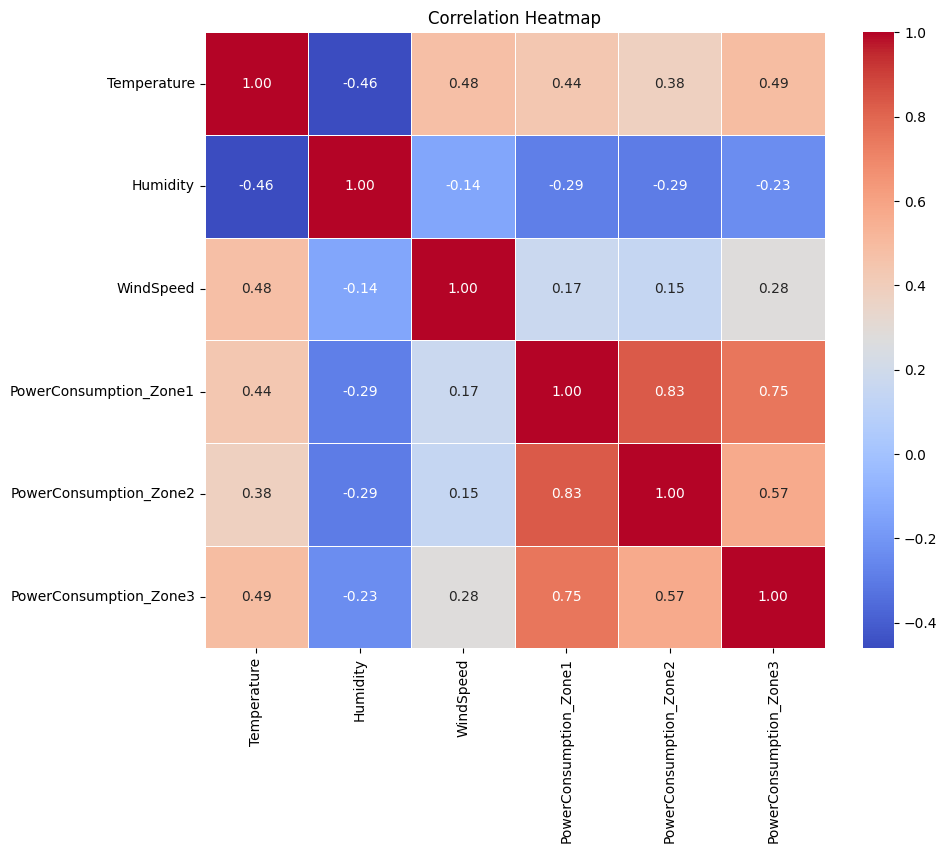

CPU times: user 395 ms, sys: 112 ms, total: 507 ms
Wall time: 424 ms


In [16]:
%%time
# Посчитаем матрицу коррелации
correlation_matrix = df[['Temperature', 'Humidity', 'WindSpeed', 'PowerConsumption_Zone1', 'PowerConsumption_Zone2', 'PowerConsumption_Zone3']].corr()

# Построим тепловую карту матрицы корреляции
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Heatmap')
plt.show()

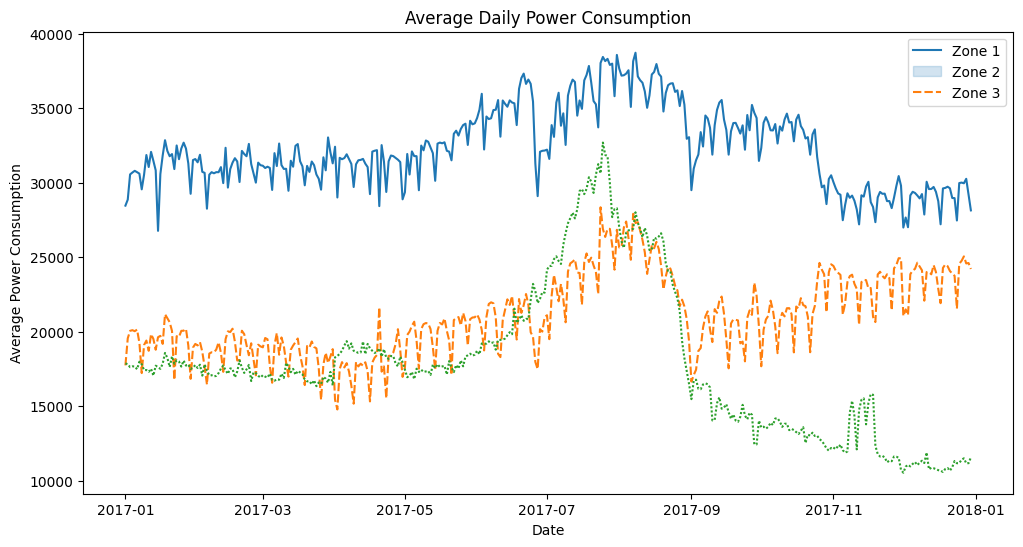

CPU times: user 442 ms, sys: 104 ms, total: 546 ms
Wall time: 472 ms


In [17]:
%%time
# Повторите выборку данных для более содержательного анализа временных рядов (например, ежедневных, еженедельных).
daily_resampled = df.resample('D').mean()

# Составьте график ежедневного энергопотребления для каждой зоны
plt.figure(figsize=(12, 6))
sns.lineplot(data=daily_resampled[['PowerConsumption_Zone1', 'PowerConsumption_Zone2', 'PowerConsumption_Zone3']])
plt.xlabel('Date')
plt.ylabel('Average Power Consumption')
plt.title('Average Daily Power Consumption')
plt.legend(labels=['Zone 1', 'Zone 2', 'Zone 3'])
plt.show()


<a id='6'></a>
# <p style="background-color:skyblue; font-family:newtimeroman; font-size:150%; text-align:center">VI. Modeling 🧩</p>

In [18]:
%%time
from sklearn.preprocessing import StandardScaler

# Разделите входные характеристики (X) и целевые переменные (y).
X = df.drop(['PowerConsumption_Zone1', 'PowerConsumption_Zone2', 'PowerConsumption_Zone3'], axis=1)
y = df[['PowerConsumption_Zone1', 'PowerConsumption_Zone2', 'PowerConsumption_Zone3']]

# Подогнать и преобразовать y
scaler_y = StandardScaler()

#
y_scaled = scaler_y.fit_transform(y)

CPU times: user 14.1 ms, sys: 4.86 ms, total: 19 ms
Wall time: 20.1 ms


In [19]:
%%time
X_train, X_test, y_train, y_test = train_test_split(X, y_scaled, test_size=0.25, shuffle=False)

CPU times: user 9.44 ms, sys: 10.9 ms, total: 20.3 ms
Wall time: 20.8 ms


<a id='6.4'></a>
## <p style="background-color:skyblue; font-family:newtimeroman; font-size:100%; text-align:center">VI. Используем Xgboost модель так как она показала себя лучше всего в сравнении с mlp, cnn и lstm</p>

In [25]:
%%time
# Define the hyperparameter grid for XGBoost
param_grid = {
    'objective':['reg:squarederror'],
    'max_depth': [2, 5, 7],
    'learning_rate': [0.1, 0.01, 0.001],
    'subsample': [0.5, 0.7],
    'n_estimators': [1000,1500,2000],
    'min_child_weight': [1, 2],
    'booster':['gbtree']
}

# Create the XGBoost model object
xgb_model = xgb.XGBRegressor(device="cuda")


# Create the GridSearchCV
grid_search = GridSearchCV(xgb_model, param_grid, cv=7, scoring='neg_mean_squared_error')

# Fit the GridSearchCV object to the training data
grid_search.fit(X_train, y_train)

# Print the best set of hyperparameters and the corresponding score
print("Best set of hyperparameters: ", grid_search.best_params_)
print("Best score: ", grid_search.best_score_)

# Evaluate the model on the test set
y_pred = grid_search.best_estimator_.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
print("Mean squared error on test set: ", mse)
print("Mean absolute error on test set: ", mae)

Best set of hyperparameters:  {'booster': 'gbtree', 'learning_rate': 0.1, 'max_depth': 5, 'min_child_weight': 2, 'n_estimators': 2000, 'objective': 'reg:squarederror', 'subsample': 0.7}
Best score:  -0.23189281518076296
Mean squared error on test set:  0.2803050930553546
Mean absolute error on test set:  0.41563700157159306
CPU times: user 1h 49min 42s, sys: 26.8 s, total: 1h 50min 9s
Wall time: 1h 48min 49s


In [26]:
%%time
model =  grid_search.best_estimator_
# model = xgb.XGBRegressor(booster='gbtree', learning_rate=0.1,
#                          max_depth=7, min_child_weight=2, n_estimators=1000,
#                          objective='reg:squarederror', subsample= 0.8)

CPU times: user 6 µs, sys: 0 ns, total: 6 µs
Wall time: 8.58 µs


In [27]:
%%time
xgboost_history = model.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
       verbose=200)

[0]	validation_0-rmse:0.91117	validation_1-rmse:0.96622
[200]	validation_0-rmse:0.10939	validation_1-rmse:0.51700
[400]	validation_0-rmse:0.08040	validation_1-rmse:0.51583
[600]	validation_0-rmse:0.06592	validation_1-rmse:0.52361
[800]	validation_0-rmse:0.05698	validation_1-rmse:0.52742
[1000]	validation_0-rmse:0.05083	validation_1-rmse:0.52725
[1200]	validation_0-rmse:0.04604	validation_1-rmse:0.52859
[1400]	validation_0-rmse:0.04230	validation_1-rmse:0.52815
[1600]	validation_0-rmse:0.03927	validation_1-rmse:0.52820
[1800]	validation_0-rmse:0.03673	validation_1-rmse:0.53004
[1999]	validation_0-rmse:0.03456	validation_1-rmse:0.52944
CPU times: user 11.4 s, sys: 31 ms, total: 11.5 s
Wall time: 11.3 s


In [28]:
%%time
# Делаем предсказание с помощью модели
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)


mse = mean_squared_error(y_test, test_predict)
mae = mean_absolute_error(y_test, test_predict)
print("Mean squared error on test set: ", mse)
print("Mean absolute error on test set: ", mae)

Mean squared error on test set:  0.2803050930553546
Mean absolute error on test set:  0.41563700157159306
CPU times: user 225 ms, sys: 2.01 ms, total: 227 ms
Wall time: 174 ms


CPU times: user 64.4 ms, sys: 992 µs, total: 65.4 ms
Wall time: 64.9 ms


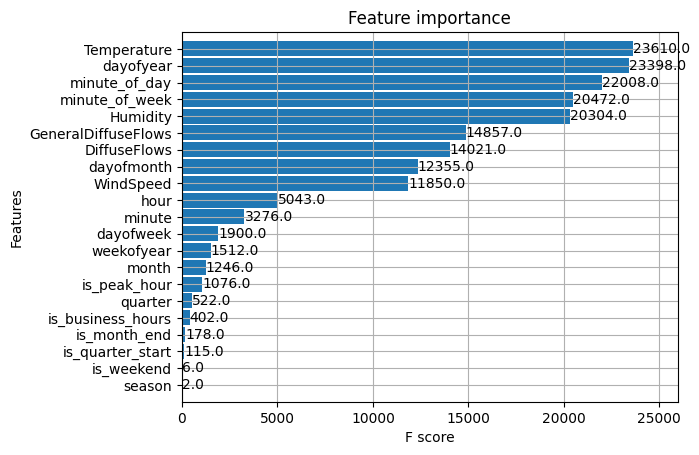

In [29]:
%%time
# Оцениваем вклад каждого признака
_ = plot_importance(model, height=0.9)

<a id='6'></a>
# <p style="background-color:skyblue; font-family:newtimeroman; font-size:150%; text-align:center">VII. Conclusions 💎</p>

The best results are taken from Xgboost.

<a id='7'></a>
# <p style="background-color:skyblue; font-family:newtimeroman; font-size:150%; text-align:center">VIII. Ссылка на источники 📝</p>

Материалы использованные для создания скрипта

* Special reference for the helpful information and plots - https://www.kaggle.com/iamleonie/intro-to-time-series-forecasting
* Special reference - https://www.kaggle.com/code/azminetoushikwasi/time-series-analysis-forecasting
* Keras LSTM - https://machinelearningmastery.com/time-series-prediction-lstm-recurrent-neural-networks-python-keras/
* Special reference - https://www.kaggle.com/code/dimitreoliveira/deep-learning-for-time-series-forecasting


# Сохраним модель для последующего использования

In [30]:
from joblib import dump

# Сохранить GridSearchCV объект
dump(grid_search, "grid_search_xgb_model.joblib")

['grid_search_xgb_model.joblib']

In [31]:
# проверим что всё верно загружается
from joblib import load

# Загрузить GridSearchCV объект
loaded_grid_search = load("grid_search_xgb_model.joblib")

# Использование загруженной модели для предсказаний
y_pred = loaded_grid_search.best_estimator_.predict(X_test)

# Оценка на тестовом наборе
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
print("Mean squared error on test set: ", mse)
print("Mean absolute error on test set: ", mae)


Mean squared error on test set:  0.2803050930553546
Mean absolute error on test set:  0.41563700157159306
